In [0]:
import imageio
import cv2
import numpy as np
import os
import pickle
import re
import PIL
from PIL import Image

## Challenge Categories

In [0]:
CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]

IMG_W = 60
IMG_H = 80
CHANNELS = 1
INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NCLASSES = 6

EPOCHS = 25
BATCH_SIZE = 64

### Spliting Dataset

In [0]:
# Dataset are divided according to the instruction at:
# http://www.nada.kth.se/cvap/actions/00sequences.txt
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]

## Loading Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
print("Loading dataset ..")
train_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/train.p", "rb"))
dev_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/test.p", "rb"))

Loading dataset ..


##Preparing dataset

In [0]:
def read_ds(ds="train"):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  for video in videos:
      for frame in video["frames"]:
          X.append(frame.reshape(INPUT_SHAPE))
          y.append(CATEGORIES.index(video["category"]))

  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)

  '''
  mean = np.mean(X)
  X -= float(mean)
  '''
  return X, y

In [0]:
X_train, y_train = read_ds(ds="train")
X_dev, y_dev = read_ds(ds="dev")
X_test, y_test = read_ds(ds="test")

In [8]:
X_train.shape

(74672, 60, 80, 1)

In [9]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [0]:
# CNN model (VGG like)
model = Sequential()

## Stage 2
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMG_W, IMG_H, CHANNELS)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Stage 3
model.add(Conv2D(64,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Stage 4
model.add(Conv2D(128,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Output
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NCLASSES,activation='softmax'))

In [27]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 58, 78, 32)        320       
_________________________________________________________________
batch_normalization_22 (Batc (None, 58, 78, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 76, 32)        9248      
_________________________________________________________________
batch_normalization_23 (Batc (None, 56, 76, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 36, 64)        18496     
_________________________________________________________________
batch_normalization_24 (Batc (None, 26, 36, 64)       

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
trained_model = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_dev, y_dev) , shuffle=True)

Train on 74672 samples, validate on 72821 samples
Epoch 1/25
74672/74672 [==============================] - 39s 527us/step - loss: 0.7084 - acc: 0.7023 - val_loss: 2.1042 - val_acc: 0.4642
Epoch 2/25
74672/74672 [==============================] - 37s 497us/step - loss: 0.3156 - acc: 0.8645 - val_loss: 2.7471 - val_acc: 0.3654
Epoch 3/25
74672/74672 [==============================] - 37s 497us/step - loss: 0.2039 - acc: 0.9146 - val_loss: 1.6449 - val_acc: 0.5291
Epoch 4/25
74672/74672 [==============================] - 37s 498us/step - loss: 0.1510 - acc: 0.9397 - val_loss: 1.6301 - val_acc: 0.5837
Epoch 5/25
74672/74672 [==============================] - 37s 498us/step - loss: 0.1181 - acc: 0.9556 - val_loss: 1.8810 - val_acc: 0.5180
Epoch 6/25
74672/74672 [==============================] - 37s 501us/step - loss: 0.0930 - acc: 0.9650 - val_loss: 1.7762 - val_acc: 0.5831
Epoch 7/25
74672/74672 [==============================] - 37s 501us/step - loss: 0.0804 - acc: 0.9716 - val_loss: 2.

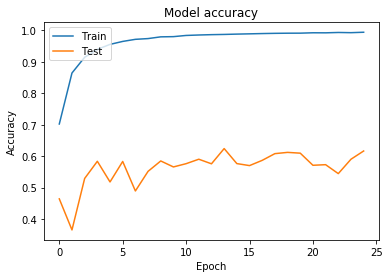

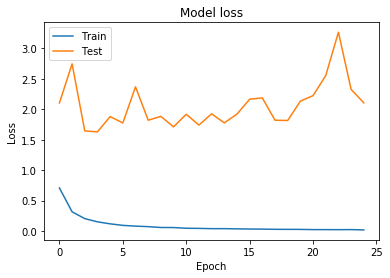

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [31]:
model.evaluate(X_test, y_test)

79266/79266 [==============================] - 13s 170us/step


[3.015544506053012, 0.559142633663866]

In [0]:
model.save_weights('CNN_KTH.h5')

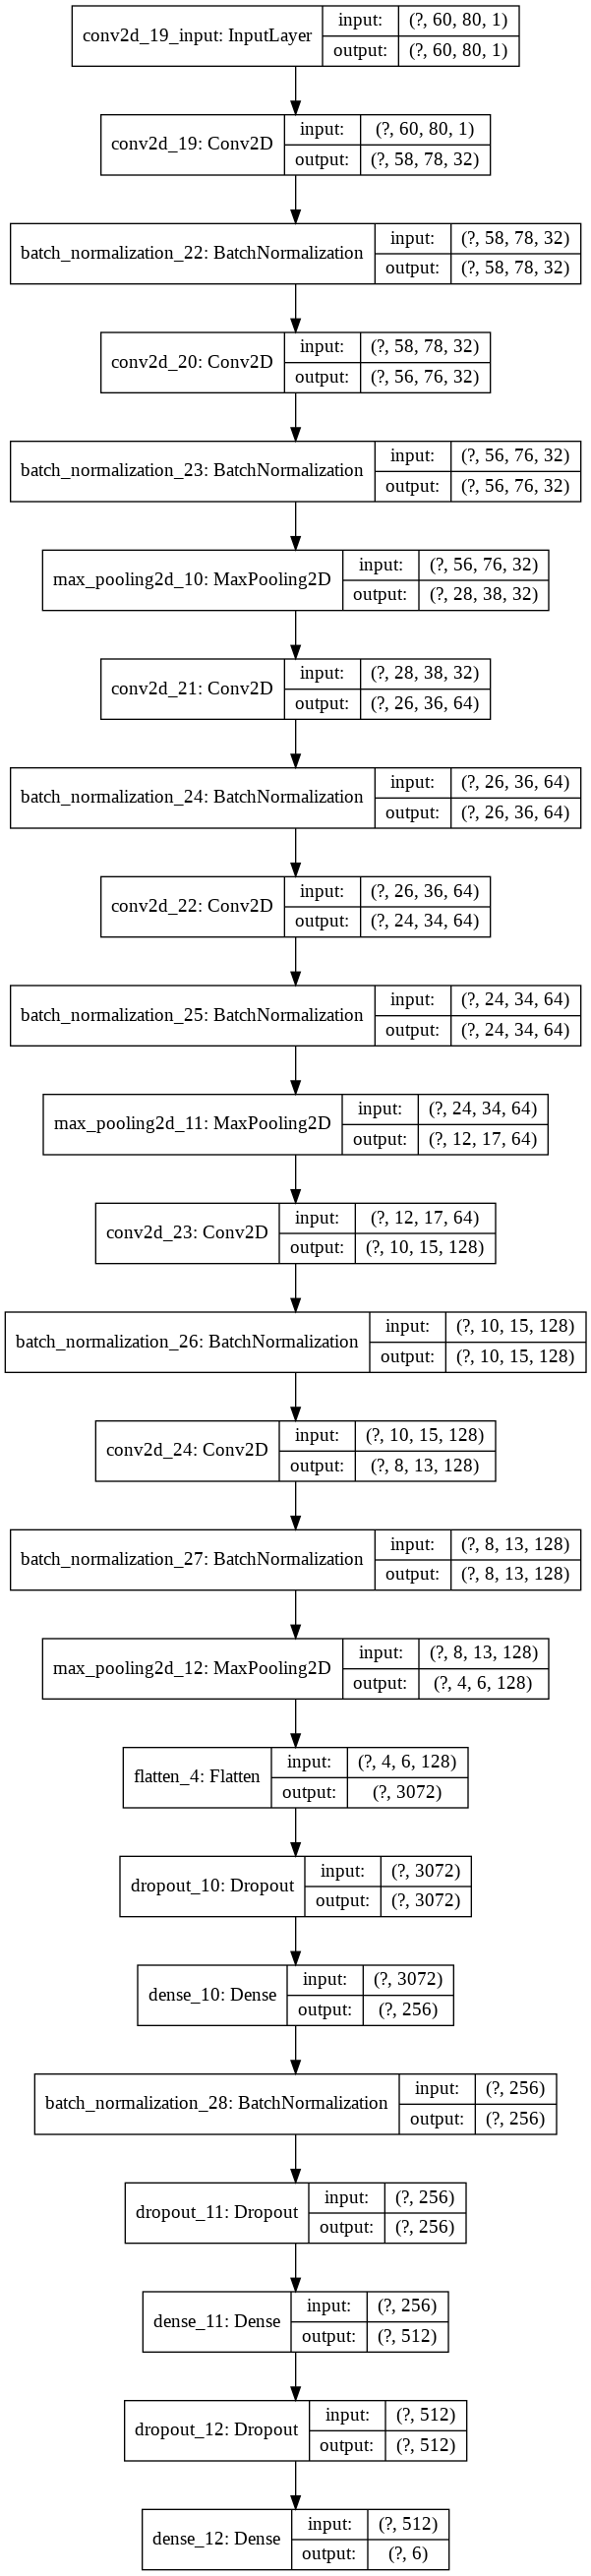

In [33]:
plot_model(model, show_shapes=True, to_file='CNN_KTH.png')